#Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import libraries

In [ ]:
seed=42
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import save_model, load_model

#Universal variables

In [ ]:
numero_cicli=2
fs=128
bpm_min=40
lunghezza_max=int(60*numero_cicli*fs/bpm_min)
input_shape = [lunghezza_max,1]
batch_size = 256
epochs = 50
LR = 0.005
patience_ES = 10
patience_LR = 5
factor_LR = 0.5

#Load data

In [ ]:
test_single_peaks_V = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_V.npy',allow_pickle=True)
test_single_peaks_N = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_N.npy',allow_pickle=True)
test_single_peaks_S = np.load('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/FINAL_DATA/test_single_peaks_S.npy',allow_pickle=True)

#Zero-padding on signals


In [ ]:
#function that zero pads single_peaks_X in order to obtain the same length for all the signals
#we thought that streatch the signals would modify them too much
def zero_pad_signals(single_peaks_X,lunghezza_max=384):
  single_peaks_X_new=[]
  for i in range(single_peaks_X.shape[0]):
    difference=lunghezza_max-single_peaks_X[i].shape[0]
    if difference%2==0:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2))],axis=0)
    else:
      new_signal=np.concatenate([np.zeros(int(difference//2)),single_peaks_X[i],np.zeros(int(difference//2+1))],axis=0)
    single_peaks_X_new.append(new_signal)
  return np.array(single_peaks_X_new)

In [ ]:
test_single_peaks_V=zero_pad_signals(test_single_peaks_V)
test_single_peaks_N=zero_pad_signals(test_single_peaks_N)
test_single_peaks_S=zero_pad_signals(test_single_peaks_S)

#X_test, y_test

In [ ]:
#[0] -> N
#[1] -> SV
X_test=np.concatenate([test_single_peaks_N,test_single_peaks_V,test_single_peaks_S],axis=0)
y_test=np.concatenate([np.zeros(test_single_peaks_N.shape[0]),np.ones(test_single_peaks_S.shape[0]),np.ones(test_single_peaks_V.shape[0])],axis=0)

#load models

In [ ]:
model1 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE1')
model2 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE2')
model3 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE3')
model4 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE4')
model5 = load_model('/content/drive/MyDrive/APPLED_AI_ASSIGMENT/TRAIN_ENSEMBLE/ENSAMBLE5')

#predictions

In [ ]:
y1=model1.predict(X_test)
y2=model2.predict(X_test)
y3=model3.predict(X_test)
y4=model4.predict(X_test)
y5=model5.predict(X_test)

707/707 [==============================] - 13s 17ms/step


#ensemble

##1:

In [ ]:
def postprocess(y,thres=0.75):
  y_post=[]
  for i in range(y.shape[0]):
    if y[i]<thres:
      y_post.append(0)
    else:
      y_post.append(1)
  return np.array(y_post)

In [ ]:
y=[]
for i in range(y1.shape[0]):
  y.append(np.mean([y1[i],y4[i],y2[i],y3[i],y5[i]]))#
y=np.array(y)

In [ ]:
y_post=postprocess(y)

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     18934
         1.0       0.65      0.90      0.76      3678

    accuracy                           0.91     22612
   macro avg       0.82      0.90      0.85     22612
weighted avg       0.93      0.91      0.91     22612



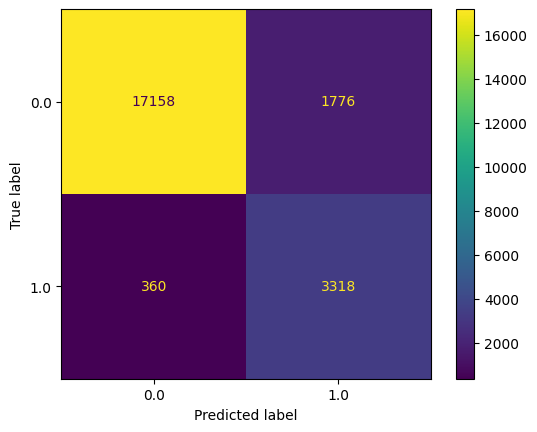

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_post)

print(classification_report(y_test,y_post))

##2:

In [ ]:
balanced_test=True
if balanced_test:
  numero=test_single_peaks_V.shape[0]+test_single_peaks_S.shape[0]
  y_post=y_post[-2*numero:]
  y_test=y_test[-2*numero:]

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      3678
         1.0       0.89      0.90      0.90      3678

    accuracy                           0.89      7356
   macro avg       0.89      0.89      0.89      7356
weighted avg       0.89      0.89      0.89      7356



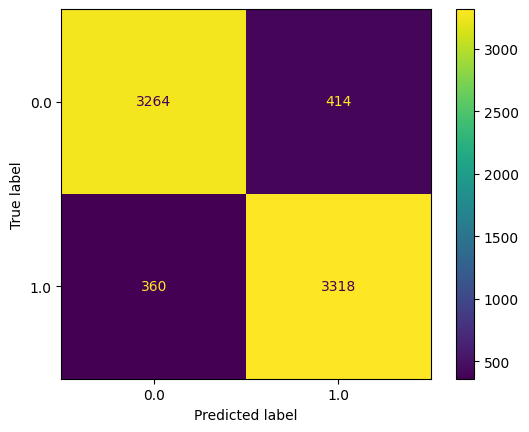

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_post)

print(classification_report(y_test,y_post))